In [22]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver  # Async SQLite checkpointer
from uuid import uuid4
import aiosqlite
import json
load_dotenv()

model = ChatOpenAI(model="gpt-4o")

In [23]:
# search_tool = TavilySearchResults(max_results=4)
from langchain_community.agent_toolkits.load_tools import load_tools
search_tools = load_tools(["google-serper"])

tools = search_tools  # Use the list directly, don't wrap in another list

# Async SQLite checkpointer with thread safety for concurrent access
# AsyncSqliteSaver handles thread safety internally, but we can still create
# a connection with explicit thread safety settings
async_conn = aiosqlite.connect(
    "checkpoint.sqlite",
    check_same_thread=False  # Allow connection across multiple threads
)
memory = AsyncSqliteSaver(async_conn)

In [24]:
llm_with_tools = model.bind_tools(tools=tools)

In [25]:
llm_with_tools.invoke("Current weather in kolkata")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ReDnTKOhvhf5oT0q6rM0hPTn', 'function': {'arguments': '{"query":"current weather in Kolkata"}', 'name': 'google_serper'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 68, 'total_tokens': 86, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BqfQ4KBg7D2RS6q7SiDNkDDS88Coc', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ec97dd41-5000-457e-b35d-fe78bdb95cbd-0', tool_calls=[{'name': 'google_serper', 'args': {'query': 'current weather in Kolkata'}, 'id': 'call_ReDnTKOhvhf5oT0q6rM0hPTn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 68, 'output_tokens': 18, 'total_t

In [26]:
from langchain_core.messages import HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return {
        "messages": [result], 
    }

async def tools_router(state: State): 
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool - access the first tool in the list
        if tool_name == "google_serper":
            # Execute the search tool with the provided arguments
            search_results = await search_tools[0].ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}

graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)


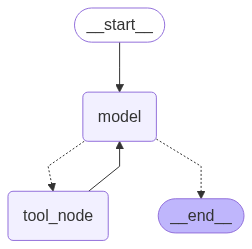

In [27]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [28]:
from uuid import uuid4

# Generate unique thread ID using UUID
thread_id = str(uuid4())
print(f"Thread ID: {thread_id}")

config = {
    "configurable": {
        "thread_id": thread_id
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="When is the next spaceX launch?")], 
}, config=config)

response

Thread ID: fff219cf-7f3f-4954-911d-cd25b63c76dd


{'messages': [HumanMessage(content='When is the next spaceX launch?', additional_kwargs={}, response_metadata={}, id='0a5cab7c-3e8b-4768-8226-c6362ed14955'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_XUStQcL6fT9BqAjTomDt4rQA', 'function': {'arguments': '{"query":"next SpaceX launch date"}', 'name': 'google_serper'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 71, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BqfQ6ZmsTeE2IAgQqNVqW2Vr47B8U', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--eaf9bdcf-7bd0-4b0d-b400-7c6bdb22b787-0', tool_calls=[{'name': 'google_serper', 'args': {'query': '

In [29]:
from uuid import uuid4

# Generate unique thread ID for streaming example
stream_thread_id = str(uuid4())
print(f"Stream Thread ID: {stream_thread_id}")

config = {
    "configurable": {
        "thread_id": stream_thread_id
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next spacex launch?")],
}, config=config, version="v2"):
    print(event)

Stream Thread ID: 0685affb-9f52-49eb-bba9-0410b67acdcd
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '5da8806f-d324-4d9c-88dd-bc471bebb0ff', 'metadata': {'thread_id': '0685affb-9f52-49eb-bba9-0410b67acdcd'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={}, id='bbf28c55-8ee1-45c9-b454-c8b4aa3bd63d')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '7e271be3-2c4d-447b-846e-a4998e622a0f', 'metadata': {'thread_id': '0685affb-9f52-49eb-bba9-0410b67acdcd', 'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:079ddab9-efa7-b832-9d94-00b350c84dfb'}, 'parent_ids': ['5da8806f-d324-4d9c-